In [1]:
!pip install torchsummary

In [5]:
import torch
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class NetLayerNorm(nn.Module):
    def __init__(self, dropout_value=0.1):
        super(NetLayerNorm, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=3, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 36, 36]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 32/3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 36, 36]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 18, 18]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 18, 18]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 20, 20]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 8, 8]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 6, 6]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 6, 6]),  # Applying LayerNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = NetLayerNorm().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 36, 36]             432
              ReLU-2           [-1, 16, 36, 36]               0
         LayerNorm-3           [-1, 16, 36, 36]          41,472
           Dropout-4           [-1, 16, 36, 36]               0
            Conv2d-5           [-1, 32, 36, 36]           4,608
              ReLU-6           [-1, 32, 36, 36]               0
         LayerNorm-7           [-1, 32, 36, 36]          82,944
           Dropout-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 16, 36, 36]             512
        MaxPool2d-10           [-1, 16, 18, 18]               0
           Conv2d-11           [-1, 32, 18, 18]           4,608
             ReLU-12           [-1, 32, 18, 18]               0
        LayerNorm-13           [-1, 32, 18, 18]          20,736
          Dropout-14           [-1

In [23]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [24]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 48859647.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [25]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


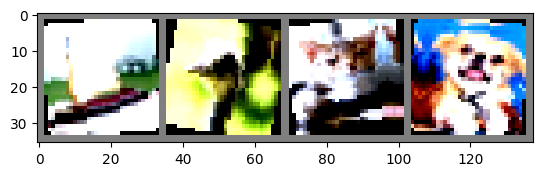

ship  bird  cat   dog  


In [27]:
 #functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [28]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    misclassified_targets = []
    misclassified_predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            misclassified_mask = pred.eq(target.view_as(pred)) == 0
            misclassified_images.append(data[misclassified_mask.view(-1)])  # Flatten the mask
            misclassified_targets.append(target[misclassified_mask.view(-1)])
            misclassified_predictions.append(pred[misclassified_mask.view(-1)])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images, misclassified_targets, misclassified_predictions

In [30]:
from torch.optim.lr_scheduler import StepLR

model =  NetLayerNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    misclassified_images, misclassified_targets, misclassified_predictions = test(model, device, test_loader)

EPOCH: 0


Loss=1.7137291431427002 Batch_id=97 Accuracy=29.13: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Test set: Average loss: 1.6314, Accuracy: 4108/10000 (41.08%)

EPOCH: 1


Loss=1.5569299459457397 Batch_id=97 Accuracy=40.87: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]



Test set: Average loss: 1.4901, Accuracy: 4554/10000 (45.54%)

EPOCH: 2


Loss=1.3797798156738281 Batch_id=97 Accuracy=46.78: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 1.3816, Accuracy: 4973/10000 (49.73%)

EPOCH: 3


Loss=1.37338125705719 Batch_id=97 Accuracy=50.89: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 1.3324, Accuracy: 5177/10000 (51.77%)

EPOCH: 4


Loss=1.272731065750122 Batch_id=97 Accuracy=53.71: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]



Test set: Average loss: 1.2146, Accuracy: 5658/10000 (56.58%)

EPOCH: 5


Loss=1.073505163192749 Batch_id=97 Accuracy=56.31: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 1.0769, Accuracy: 6140/10000 (61.40%)

EPOCH: 6


Loss=1.1568782329559326 Batch_id=97 Accuracy=58.54: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Test set: Average loss: 1.0605, Accuracy: 6189/10000 (61.89%)

EPOCH: 7


Loss=1.171527624130249 Batch_id=97 Accuracy=59.84: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]



Test set: Average loss: 1.1077, Accuracy: 6078/10000 (60.78%)

EPOCH: 8


Loss=1.1051054000854492 Batch_id=97 Accuracy=60.87: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]



Test set: Average loss: 1.0274, Accuracy: 6367/10000 (63.67%)

EPOCH: 9


Loss=1.0924402475357056 Batch_id=97 Accuracy=62.18: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]



Test set: Average loss: 0.9351, Accuracy: 6652/10000 (66.52%)

EPOCH: 10


Loss=1.0483622550964355 Batch_id=97 Accuracy=62.91: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]



Test set: Average loss: 0.9358, Accuracy: 6648/10000 (66.48%)

EPOCH: 11


Loss=1.0700132846832275 Batch_id=97 Accuracy=63.67: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]



Test set: Average loss: 0.9423, Accuracy: 6639/10000 (66.39%)

EPOCH: 12


Loss=1.0285669565200806 Batch_id=97 Accuracy=64.20: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.9117, Accuracy: 6737/10000 (67.37%)

EPOCH: 13


Loss=1.0391724109649658 Batch_id=97 Accuracy=64.71: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.8699, Accuracy: 6909/10000 (69.09%)

EPOCH: 14


Loss=1.0434573888778687 Batch_id=97 Accuracy=64.79: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 0.9429, Accuracy: 6619/10000 (66.19%)

EPOCH: 15


Loss=0.9907974004745483 Batch_id=97 Accuracy=66.03: 100%|██████████| 98/98 [00:30<00:00,  3.27it/s]



Test set: Average loss: 0.9033, Accuracy: 6760/10000 (67.60%)

EPOCH: 16


Loss=0.9176818132400513 Batch_id=97 Accuracy=66.43: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.8514, Accuracy: 6992/10000 (69.92%)

EPOCH: 17


Loss=0.8845818638801575 Batch_id=97 Accuracy=67.22: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.8491, Accuracy: 6920/10000 (69.20%)

EPOCH: 18


Loss=0.9145662188529968 Batch_id=97 Accuracy=67.31: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.8572, Accuracy: 6968/10000 (69.68%)

EPOCH: 19


Loss=0.8947186470031738 Batch_id=97 Accuracy=67.51: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.8206, Accuracy: 7111/10000 (71.11%)



Text(0.5, 1.0, 'Test Accuracy')

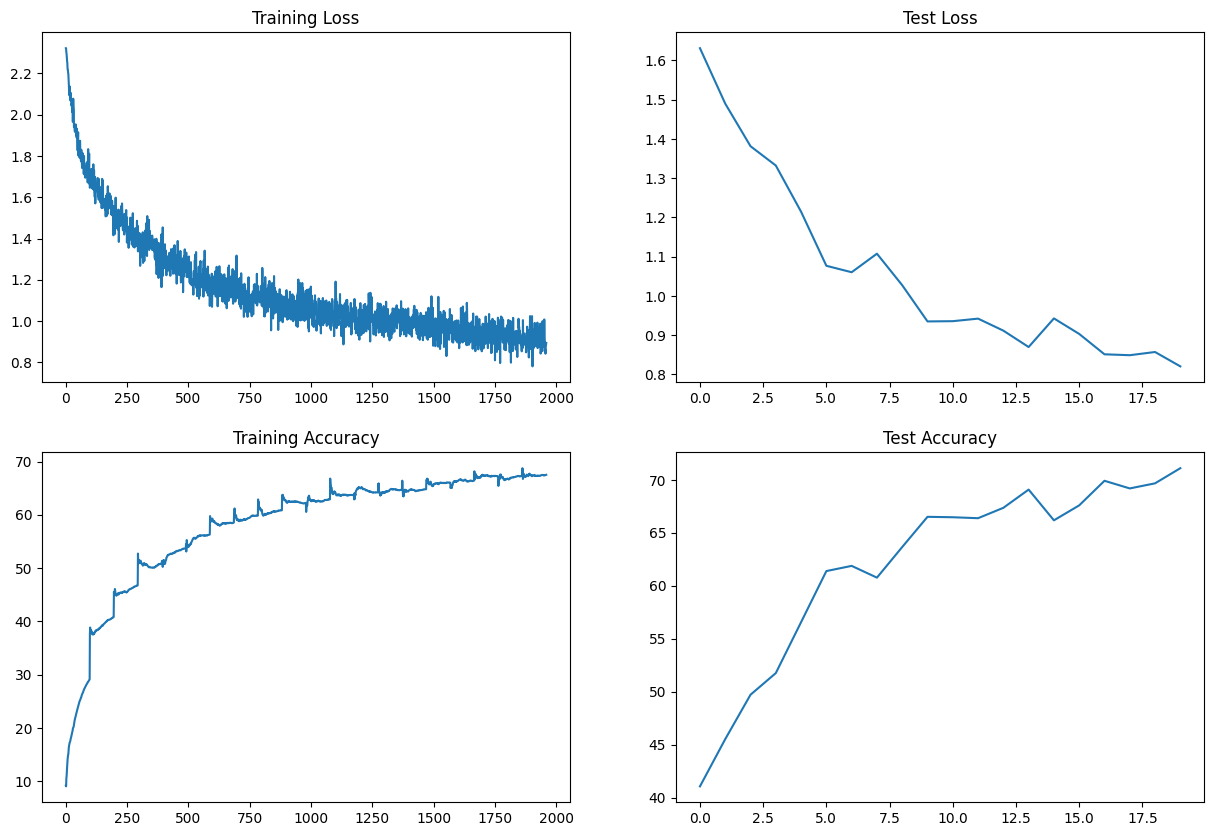

In [31]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:

# Sample 10 misclassified images
num_samples = 10
sample_indices = np.random.choice(len(misclassified_images), min(num_samples, len(misclassified_images)), replace=False)

# Plot misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(sample_indices):
        ax.imshow(misclassified_images[sample_indices[i]][0].cpu().numpy().transpose((1, 2, 0)))
        ax.set_title(f"True: {misclassified_targets[sample_indices[i]][0].item()}, Pred: {misclassified_predictions[sample_indices[i]][0].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

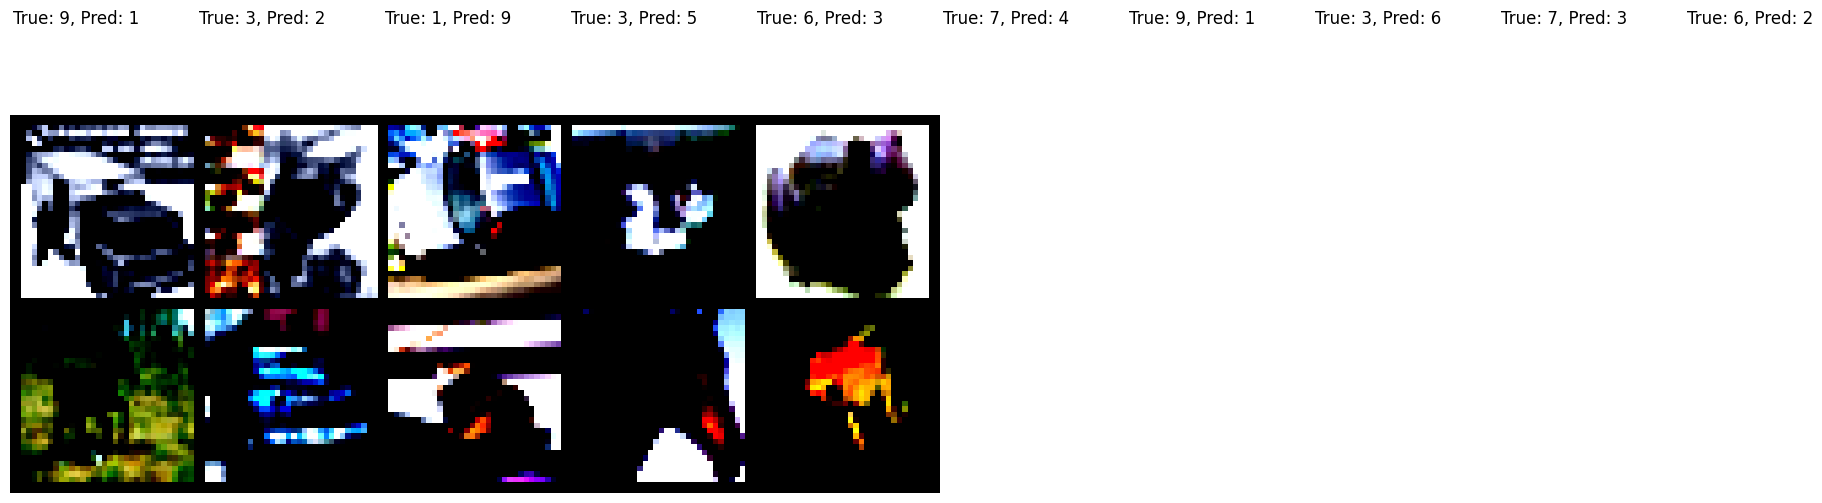

In [34]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Sample 10 misclassified images
num_samples = 10
sample_indices = torch.randperm(len(misclassified_images))[:min(num_samples, len(misclassified_images))]

# Prepare images and labels for plotting
images = [misclassified_images[idx][0].cpu() for idx in sample_indices]
labels_true = [misclassified_targets[idx][0].item() for idx in sample_indices]
labels_pred = [misclassified_predictions[idx][0].item() for idx in sample_indices]

# Plot misclassified images using torch grid
img_grid = make_grid(images, nrow=5)
plt.figure(figsize=(12, 6))
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())  # Move tensor to CPU and convert to numpy array
plt.axis('off')

# Add titles to each sub-image
for i in range(num_samples):
    plt.text(i * img_grid.shape[2] / 5, -20, f'True: {labels_true[i]}, Pred: {labels_pred[i]}', fontsize=12, ha='left', color='black', va='top', rotation=0)

plt.show()
